# Predicting daily bikerider count from temperature and weekday

**What is the main question your project aims to answer?**

Can we predict the number of daily bike riders counted at a "bike counting station" in Freiburg, based on the local temperature information and information about whether the given day is a business day or weekend?

**Which dataset will you use?**

We derive daily bike rider counts at a counting station in Freiburg in 2021 from the hourly measurements given in: https://www.mobidata-bw.de/dataset/eco-counter-fahrradzahler.

We combine this data with temperature data taken from https://open-meteo.com/en/docs/historical-weather-api.

(Business-day vs. weekend: Whether a given date is a business day or weekend can be inferred computationally from the date.)

**What analysis will you perform?**

We construct a linear regression model, assuming the number of counted bikeriders per day is a normally distributed variable depending on the mean temperature on the given day and whether the given day is a business day. We fit the model using Bayesian inference.

Um obige Ziele umzusetzen, stellen uns einen Datensatz zusammen, der folgende Daten enthält:

- tägliche Anzahl gemessener Fahrradfahrer von Zähler in Freiburg (channel name: 'FR1 Dreisam / Hindenburgstr.')
- mittlere tägliche Temperatur
- boolean, ob Tag Wochentag oder Werktag ist

Dazu importieren wir im Folgenden stündliche Zählerstände verschiedener Fahrradfahrerzählstationen aus dem Jahr 2021. Aus diesen Daten berechnen wir tägliche Zählersummen.

Wir extrahieren die Daten von genau einem Zähler (Freiburg, channel name: 'FR1 Dreisam / Hindenburgstr.') und betrachten in der Analyse nur die täglichen Zählersummen dieses Zählers.

Für den Standort dieses Zählers importieren wir Temperaturdaten.

Außerdem berechnen wir für jedes Datum vom 2021-01-01 bis 2021-12-31, ob es sich dabei um einen Werktag oder Wochenende handelt.

All diese Daten fügen wir dann in einem gemeinsamen Datensatz zusammen. Dieser ist weiter unten als 'combined_daily_dat' zu finden.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

import pymc3 as pm
import arviz as az

## Import bike rider counts data

In [2]:
# paths to data (one file per month)
dat_paths = ['./../Daten/eco_counter_fahrradzaehler_20210' + str(i) + '.csv' for i in range(1,10)]
dat_paths = dat_paths + ['./../Daten/eco_counter_fahrradzaehler_2021' + str(i) + '.csv' for i in range(10,13)]

# read in the data
dats = [pd.read_csv(path) for path in dat_paths]

# concatenate monthly data to get data of whole year in one dataframe
dat = pd.concat(dats)

In [3]:
# check whether import of data worked
dat.head()

,timestamp,iso_timestamp,zählstand,stand,standort,channel_name,channel_id,counter_site,counter_site_id,domain_name,domain_id,longitude,latitude,timezone,interval,counter_serial
0,2021-01-01T01:00:00+0000,2021-01-01T01:00:00+0100,2,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496
1,2021-01-01T02:00:00+0000,2021-01-01T02:00:00+0100,0,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496
2,2021-01-01T03:00:00+0000,2021-01-01T03:00:00+0100,1,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496
3,2021-01-01T04:00:00+0000,2021-01-01T04:00:00+0100,1,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496
4,2021-01-01T05:00:00+0000,2021-01-01T05:00:00+0100,2,0,Stadt Heidelberg,Channel 1 Richtung West,101012161,Plöck,100012161,NVBW - Nahverkehrsgesellschaft Baden- Württemberg,6598,8.698543,49.40913,(UTC+01:00) Europe/Berlin;DST,15,Y2H22032496


Eine Zeile entspricht einer Messung. Gemessen wird stündlich. Nicht für jede Messstelle sind das ganze Jahr über Daten gelistet.

Bisher versteht ich den Datensatz folgendermaßen:  
Innerhalb eines 'standort' (siehe Spaltenname oben) gibt es verschiedene 'counter_site', an denen es wiederum verschiedene 'channel_name' geben kann.

Beispiel:  
Am Standort 'Stadt Freiburg' gibt es 3 'counter_sites' ('FR1 Dreisam / Otto-Wels-Str.', 'FR2 Güterbahn / Ferd.-Weiß-Str.', und 'FR3 Eschholzstr. / Egonstr.'), an denen es dann wiederum jeweils 'channel_name' gibt.

In [4]:
# add date information (whether it is a business day) to dataframe
# TODO Zeitzone beachten...

def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))

# make 'timestamp' date and determine for each date whether it is a business day
dat['timestamp'] = pd.to_datetime(dat['timestamp'])
dat['is_busday'] = dat['timestamp'].apply(is_business_day)

# add simpler date format to each measurement to make grouping by day easier
dat['date'] = dat['timestamp'].dt.date

## Compute daily counts

Measurements (bike rider counts) above are given hourly. Now, we sum them to get daily counts.

In [5]:
# sum counts of one day at one counting station
counters_by_daytype_daily = dat.groupby(by=['standort', 'counter_site', 'channel_name', 'date', 'is_busday'], as_index=False)['zählstand'].sum()

In [6]:
counters_by_daytype_daily

,standort,counter_site,channel_name,date,is_busday,zählstand
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-01,True,521
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-02,False,1131
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-03,False,763
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-04,True,1607
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-05,True,1668
...,...,...,...,...,...,...
27586,Stadt Ulm,Blautal Lupferbrücke,Blautal Lupferbrücke Ri. Süden,2021-04-26,True,654
27587,Stadt Ulm,Blautal Lupferbrücke,Blautal Lupferbrücke Ri. Süden,2021-04-27,True,709
27588,Stadt Ulm,Blautal Lupferbrücke,Blautal Lupferbrücke Ri. Süden,2021-04-28,True,630
27589,Stadt Ulm,Blautal Lupferbrücke,Blautal Lupferbrücke Ri. Süden,2021-04-29,True,382


## Extract daily counts of a single channel in Freiburg

For the analysis, consider the daily bike rider counts from a single counting channel in Freiburg.

shape:  (365, 6)


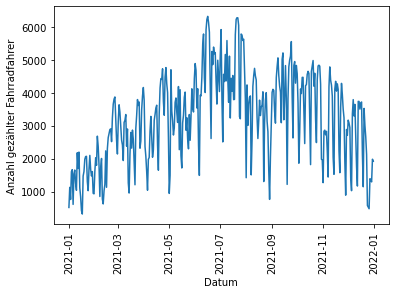

In [7]:
# plot daily counts of Freiburg at one counter site and for one channel for one year
# (TODO rausfinden, was die verschiedenen Channels sind)

# counting station
city_name = 'Stadt Freiburg'
counter_site = 'FR1 Dreisam / Otto-Wels-Str.'
channel_name = 'FR1 Dreisam / Hindenburgstr.'

# extract data
fr1_dat = counters_by_daytype_daily[(counters_by_daytype_daily.standort == city_name) & (counters_by_daytype_daily.counter_site == counter_site) & (counters_by_daytype_daily.channel_name == channel_name)]

# print shape
print('shape: ', fr1_dat.shape) # daily summed measurements for each of the 365 days in 2021

# plot daily counts for this channel
plt.plot(fr1_dat['date'], fr1_dat['zählstand'])
plt.xticks(rotation=90)
plt.xlabel('Datum')
plt.ylabel('Anzahl gezählter Fahrradfahrer');

In [8]:
fr1_dat

,standort,counter_site,channel_name,date,is_busday,zählstand
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-01,True,521
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-02,False,1131
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-03,False,763
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-04,True,1607
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-05,True,1668
...,...,...,...,...,...,...
360,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-27,True,1394
361,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-28,True,1353
362,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-29,True,1297
363,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-30,True,1985


## Find and add temperature data

In [9]:
# find coordinates of channel location
print('latitude:', set(dat[(dat.standort == city_name) & (dat.counter_site == counter_site) & (dat.channel_name == channel_name)]['latitude']))
print('longitude:', set(dat[(dat.standort == city_name) & (dat.counter_site == counter_site) & (dat.channel_name == channel_name)]['longitude']))

# Given the location, one can download the temperature data from https://open-meteo.com/en/docs/historical-weather-api.

latitude: {47.99054}
longitude: {7.8623013}


In [10]:
# import temperature data for the given location of the counting station
weather_dat = pd.read_csv('./../Daten/era5.csv', header=2)
weather_dat

,time,temperature_2m (°C),relativehumidity_2m (%),apparent_temperature (°C),precipitation (mm),cloudcover (%)
0,2021-01-01T00:00,3.3,91,0.8,0.0,100
1,2021-01-01T01:00,2.8,93,0.2,0.0,100
2,2021-01-01T02:00,2.6,93,-0.1,0.0,100
3,2021-01-01T03:00,2.3,95,-0.3,0.1,100
4,2021-01-01T04:00,2.0,96,-0.4,0.0,100
...,...,...,...,...,...,...
8755,2021-12-31T19:00,8.6,91,6.4,0.0,21
8756,2021-12-31T20:00,7.8,94,5.6,0.0,21
8757,2021-12-31T21:00,7.3,95,5.2,0.0,16
8758,2021-12-31T22:00,6.3,97,4.0,0.0,17


In [11]:
# convert to date
weather_dat['time'] = pd.to_datetime(weather_dat['time'])

# add simpler date format to each measurement to make grouping by day easier
weather_dat['date'] = weather_dat['time'].dt.date

In [12]:
# get daily mean temperature
daily_mean_temp = weather_dat.groupby(by=['date'], as_index=False)['temperature_2m (°C)'].mean()
daily_mean_temp

,date,temperature_2m (°C)
0,2021-01-01,1.845833
1,2021-01-02,0.845833
2,2021-01-03,0.495833
3,2021-01-04,0.733333
4,2021-01-05,0.616667
...,...,...
360,2021-12-27,7.466667
361,2021-12-28,9.925000
362,2021-12-29,9.554167
363,2021-12-30,13.116667


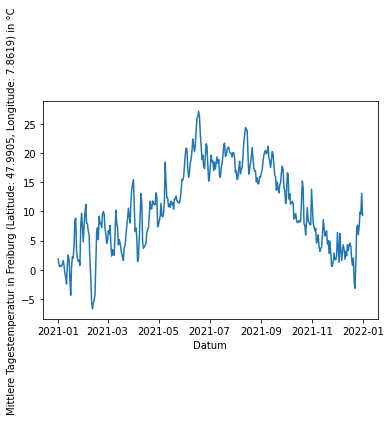

In [13]:
# plot daily mean temperature
plt.plot(daily_mean_temp['date'], daily_mean_temp['temperature_2m (°C)'])
plt.xlabel('Datum')
plt.ylabel('Mittlere Tagestemperatur in Freiburg (Latitude: 47.9905, Longitude: 7.8619) in °C');

## Merge bike rider counts and temperature information

In [14]:
# combine the daily bikerider counts and temperature information
combined_daily_dat = pd.merge(fr1_dat, daily_mean_temp, on='date')
combined_daily_dat

,standort,counter_site,channel_name,date,is_busday,zählstand,temperature_2m (°C)
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-01,True,521,1.845833
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-02,False,1131,0.845833
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-03,False,763,0.495833
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-04,True,1607,0.733333
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-05,True,1668,0.616667
...,...,...,...,...,...,...,...
360,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-27,True,1394,7.466667
361,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-28,True,1353,9.925000
362,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-29,True,1297,9.554167
363,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-30,True,1985,13.116667


In [15]:
# adjust column names
combined_daily_dat.rename(columns = {'temperature_2m (°C)':'temperature', 'zählstand':'rider_count'}, inplace = True)
combined_daily_dat

,standort,counter_site,channel_name,date,is_busday,rider_count,temperature
0,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-01,True,521,1.845833
1,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-02,False,1131,0.845833
2,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-03,False,763,0.495833
3,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-04,True,1607,0.733333
4,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-01-05,True,1668,0.616667
...,...,...,...,...,...,...,...
360,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-27,True,1394,7.466667
361,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-28,True,1353,9.925000
362,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-29,True,1297,9.554167
363,Stadt Freiburg,FR1 Dreisam / Otto-Wels-Str.,FR1 Dreisam / Hindenburgstr.,2021-12-30,True,1985,13.116667


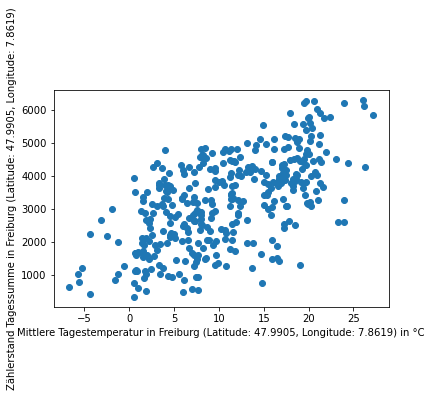

In [16]:
# plot daily bikerider count by mean day temperature
plt.scatter(combined_daily_dat['temperature'], combined_daily_dat['rider_count'])
plt.xlabel('Mittlere Tagestemperatur in Freiburg (Latitude: 47.9905, Longitude: 7.8619) in °C')
plt.ylabel('Zählerstand Tagessumme in Freiburg (Latitude: 47.9905, Longitude: 7.8619)');

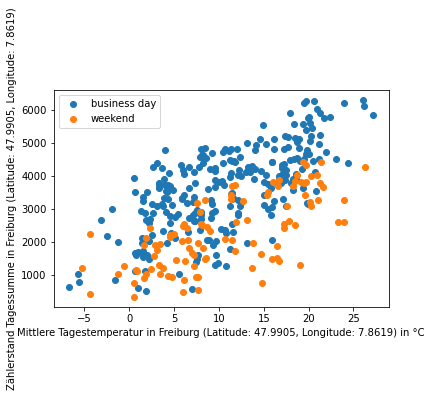

In [17]:
# plot daily bikerider count by mean day temperature, separate between business days and weekends
plt.scatter(combined_daily_dat[combined_daily_dat['is_busday'] == True]['temperature'], combined_daily_dat[combined_daily_dat['is_busday'] == True]['rider_count'], label='business day')
plt.scatter(combined_daily_dat[combined_daily_dat['is_busday'] == False]['temperature'], combined_daily_dat[combined_daily_dat['is_busday'] == False]['rider_count'], label='weekend')
plt.legend()
plt.xlabel('Mittlere Tagestemperatur in Freiburg (Latitude: 47.9905, Longitude: 7.8619) in °C')
plt.ylabel('Zählerstand Tagessumme in Freiburg (Latitude: 47.9905, Longitude: 7.8619)');

## Statistical Analysis (Frequentist)

In [18]:
# fit linear Gaussian model to the daily bike rider counts data,
# predictors: mean day temperature and being a business day

fit_daily_counts = smf.glm(
    formula='rider_count ~ temperature * is_busday',
    data=combined_daily_dat).fit()

# check the fit result
print(fit_daily_counts.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            rider_count   No. Observations:                  365
Model:                            GLM   Df Residuals:                      361
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                      7.8842e+05
Method:                          IRLS   Log-Likelihood:                -2993.8
Date:                Sat, 03 Dec 2022   Deviance:                   2.8462e+08
Time:                        10:21:05   Pearson chi2:                 2.85e+08
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7351
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

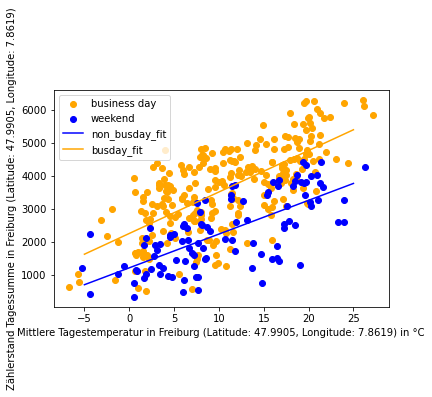

In [19]:
# plot

# plot data
plt.scatter(combined_daily_dat[combined_daily_dat['is_busday'] == True]['temperature'], combined_daily_dat[combined_daily_dat['is_busday'] == True]['rider_count'], label='business day', color='orange')
plt.scatter(combined_daily_dat[combined_daily_dat['is_busday'] == False]['temperature'], combined_daily_dat[combined_daily_dat['is_busday'] == False]['rider_count'], label='weekend', color='blue')

# plot fit
x_temps = np.linspace(-5, 25, 10)
plt.plot(x_temps, fit_daily_counts.params['Intercept'] +  x_temps * fit_daily_counts.params['temperature'], label='non_busday_fit', color='blue')
plt.plot(x_temps, fit_daily_counts.params['Intercept'] + fit_daily_counts.params['is_busday[T.True]'] +  x_temps * (fit_daily_counts.params['temperature'] + fit_daily_counts.params['temperature:is_busday[T.True]']), label='busday_fit', color='orange')

plt.xlabel('Mittlere Tagestemperatur in Freiburg (Latitude: 47.9905, Longitude: 7.8619) in °C')
plt.ylabel('Zählerstand Tagessumme in Freiburg (Latitude: 47.9905, Longitude: 7.8619)')
plt.legend();

## Statistical Analysis with Bayes

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_slope, beta_intercept]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 6 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_intercept[0],1207.956,133.027,956.525,1462.681,1.856,1.313,5148.0,4863.0,1.0
beta_intercept[1],2243.816,104.319,2045.042,2435.117,1.467,1.037,5059.0,5250.0,1.0
beta_slope[0],102.640,10.374,82.448,122.176,0.144,0.102,5179.0,4478.0,1.0
beta_slope[1],126.698,8.211,111.287,142.052,0.116,0.082,4984.0,5090.0,1.0
sigma[0],762.536,51.503,670.517,862.310,0.579,0.410,7925.0,5058.0,1.0
sigma[1],914.909,39.238,843.571,988.807,0.465,0.329,7144.0,5213.0,1.0


no busday mean beta0:  1207.95607  , mean beta1:  102.63991
busday mean beta0:  2243.81623  , mean beta1:  126.69762


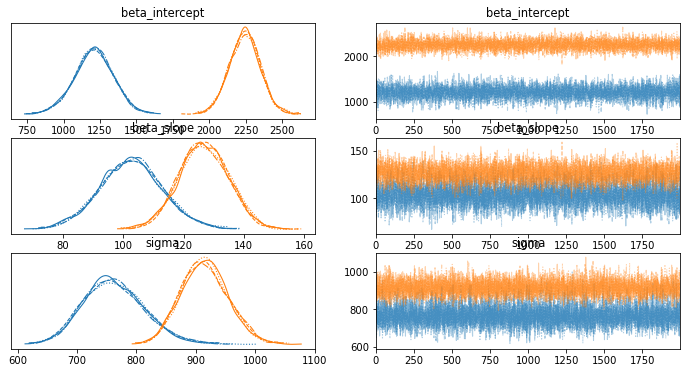

In [20]:
# build linear model with categories "business-day vs no-business-day"

with pm.Model() as linearCategoricalModel:
    
    # TODO prior anpassen
    # prior for parameter vector beta (2x intercept, 2x gain)
    beta_intercept = pm.Normal("beta_intercept", mu=0, sigma=1000, shape=2)
    beta_slope = pm.Normal("beta_slope", mu=0, sigma=100, shape=2)
    
    # prior for two noise distributions: better small
    sigma = pm.Exponential("sigma", lam=.01, shape=2)
    
    # the linear model function: 2 separate categories
    expected = (beta_intercept[0] + beta_slope[0] * combined_daily_dat['temperature']) * (1-combined_daily_dat['is_busday']) + \
               (beta_intercept[1] + beta_slope[1] * combined_daily_dat['temperature']) * combined_daily_dat['is_busday']
    
    # Data and Likelihood: Gaussian noise
    noise = sigma[0] * (1 - combined_daily_dat['is_busday']) + sigma[1] * combined_daily_dat['is_busday']
    obs = pm.Normal("observed",
                    mu=expected,
                    sigma=noise,
                    observed=combined_daily_dat['rider_count'])

    
# sample
with linearCategoricalModel:
    trace = pm.sample(2000, chains=4, tune=3000, target_accept=0.9, return_inferencedata=False)

# show results
with linearCategoricalModel:
    pm.plot_trace(trace)
    display(pm.summary(trace))

# extract betas
with linearCategoricalModel:
    postbetas_intercept = trace["beta_intercept"]
    postbetas_slope = trace["beta_slope"]

# compute mean betas
meanbetas_intercept = postbetas_intercept.mean(axis=0)
meanbetas_slope = postbetas_slope.mean(axis=0)

# print mean betas
print('no busday', 'mean beta0: ', round(meanbetas_intercept[0], 5), ' , mean beta1: ', round(meanbetas_slope[0], 5))
print('busday', 'mean beta0: ', round(meanbetas_intercept[1], 5), ' , mean beta1: ', round(meanbetas_slope[1], 5))

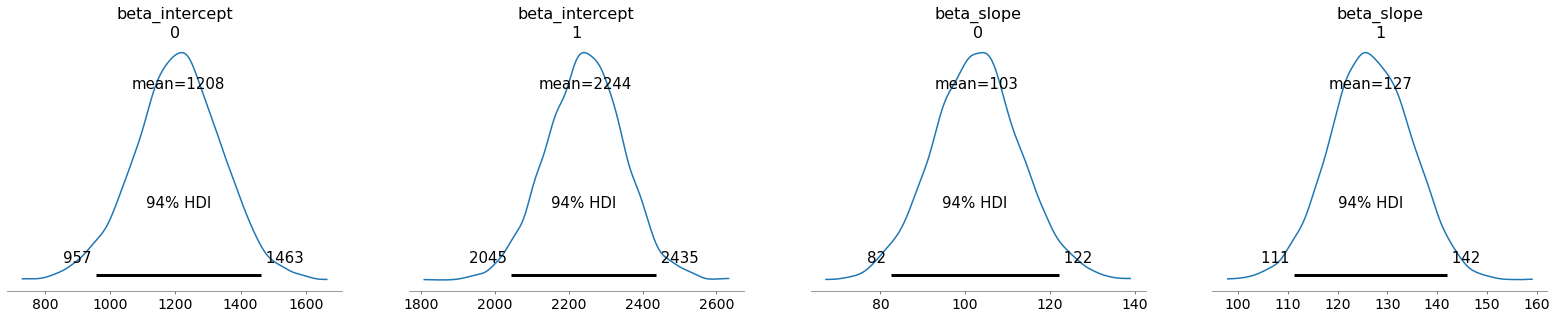

In [21]:
with linearCategoricalModel:
    ax = az.plot_posterior(trace, var_names=['beta_intercept', 'beta_slope'])

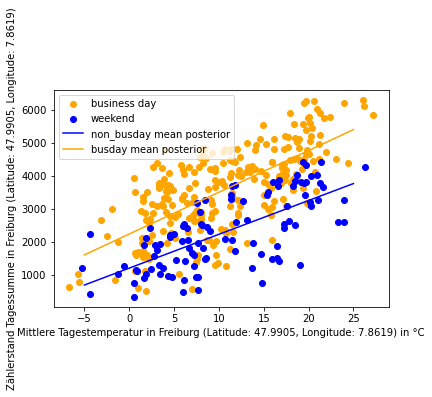

In [22]:
# plot

# plot data
plt.scatter(combined_daily_dat[combined_daily_dat['is_busday'] == True]['temperature'], combined_daily_dat[combined_daily_dat['is_busday'] == True]['rider_count'], label='business day', color='orange')
plt.scatter(combined_daily_dat[combined_daily_dat['is_busday'] == False]['temperature'], combined_daily_dat[combined_daily_dat['is_busday'] == False]['rider_count'], label='weekend', color='blue')

# plot fit
x_temps = np.linspace(-5, 25, 10)
plt.plot(x_temps, meanbetas_intercept[0] +  x_temps * meanbetas_slope[0], label='non_busday mean posterior', color='blue')
plt.plot(x_temps, meanbetas_intercept[1] +  x_temps * meanbetas_slope[1], label='busday mean posterior', color='orange')

plt.xlabel('Mittlere Tagestemperatur in Freiburg (Latitude: 47.9905, Longitude: 7.8619) in °C')
plt.ylabel('Zählerstand Tagessumme in Freiburg (Latitude: 47.9905, Longitude: 7.8619)')
plt.legend();